In [1]:
import pickle
import numpy as np
import os

from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
import cv2
%matplotlib inline

In [2]:
from train_csr import ImageDataset, OpensetRecognizer
import random

# Prepare data and model

In [3]:
data_path = 'data/'
openset_model = OpensetRecognizer(data_path='data/', feature_dim=128)

In [4]:
# losses, accs = openset_model.train_model(n_epochs=50)
# json.dump({'accs': accs, 'losses': losses}, open('stats.json', 'w'))
#openset_model.load_model('models/5')

In [5]:
openset_model.load_model('models/35')

In [6]:
test_data = pickle.load(open(os.path.join(data_path, 'test_data.pickle'), 'rb'))
test_labels = pickle.load(open(os.path.join(data_path, 'test_labels.pickle'), 'rb'))

open_data = pickle.load(open(os.path.join(data_path, 'opendata.pickle'), 'rb'))
open_labels = pickle.load(open(os.path.join(data_path, 'open_labels.pickle'), 'rb'))

open_labels_set = sorted(list(set(open_labels)))
test_labels_set = sorted(list(set(test_labels)))
test_labels_mapping = {test_labels_set[i]:i for i in range(len(test_labels_set))}
open_labels_mapping = {open_labels_set[i]:i + len(test_labels_set) for i in range(len(open_labels_set))}

test_data = np.stack(test_data)
open_data = np.stack(open_data)
test_labels = np.array([test_labels_mapping[item] for item in test_labels])
open_labels = np.array([open_labels_mapping[item] for item in open_labels])

test_dataset = ImageDataset(test_data, test_labels, n_classes=7, ls_eps=0, transform=openset_model.val_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, drop_last=False, collate_fn=openset_model.val_collate)

open_dataset = ImageDataset(open_data, test_labels, n_classes=7, ls_eps=0, transform=openset_model.val_transform)
open_loader = DataLoader(open_dataset, batch_size=4, shuffle=False, drop_last=False, collate_fn=openset_model.val_collate)


In [7]:
openset_model.prepare_detection_model()

100%|██████████| 17/17 [00:03<00:00,  4.80it/s]


Train Classification Accuracy =  0.9400386847195358
MLS stats: mean=2.872923497694258, std=0.9415704954307164


In [8]:
n = len(test_dataset)
m = len(open_dataset)
i, j = random.sample(range(n), 1)[0], random.sample(range(m), 1)[0]
print(i, j)

2 36


In [9]:
tensor_test, _ = test_dataset[i]
tensor_open, _ = open_dataset[j]
img_test, label_test = test_dataset.view(i)
img_open, label_open = open_dataset.view(j)

# Test interpretability

In [15]:
cams = openset_model.get_cam(tensor_test.unsqueeze(0), (img_test.shape[1], img_test.shape[0]), labels=[label_test], cam_model_name='GradCAM')

In [16]:
# from pytorch_grad_cam.utils.image import show_cam_on_image
# n = (len(cams) - 1) // 1 + 1
# m = 1
# fig, ax = plt.subplots(n, m, squeeze=False)
# fig.set_size_inches(15, 15 * m / n)
# for i in range(len([img_test])):
#     u = show_cam_on_image([img_test][i].astype(np.float32) / 255, cams[i], use_rgb=True)

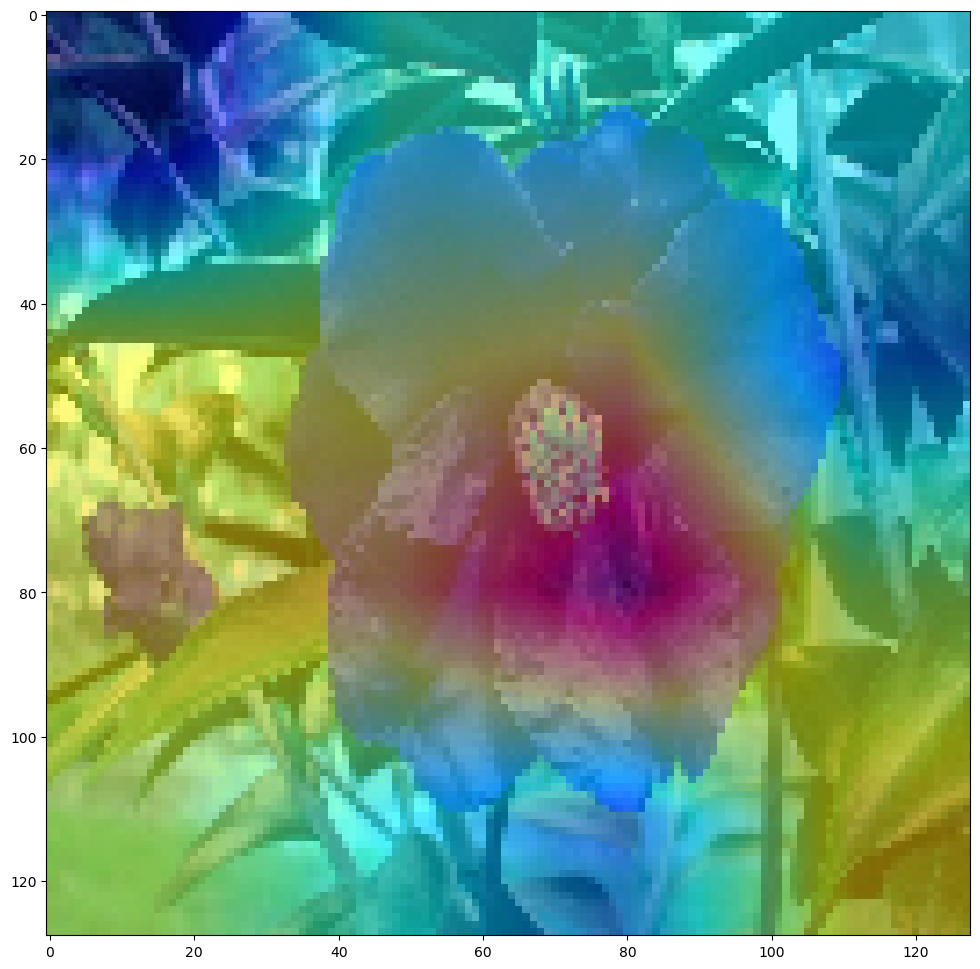

In [17]:
viz = openset_model.visualize_cams([img_test], cams, max_width=1, output_path='fig1.png')

In [18]:
cams = openset_model.get_cam(tensor_open.unsqueeze(0).repeat(openset_model.n_classes, 1, 1, 1), (img_open.shape[1], img_open.shape[0]), labels=[i for i in range(openset_model.n_classes)], cam_model_name='GradCAM')

In [19]:
len(cams)

7

In [20]:
open_cam = np.amin(1 - np.stack(cams), axis=0)

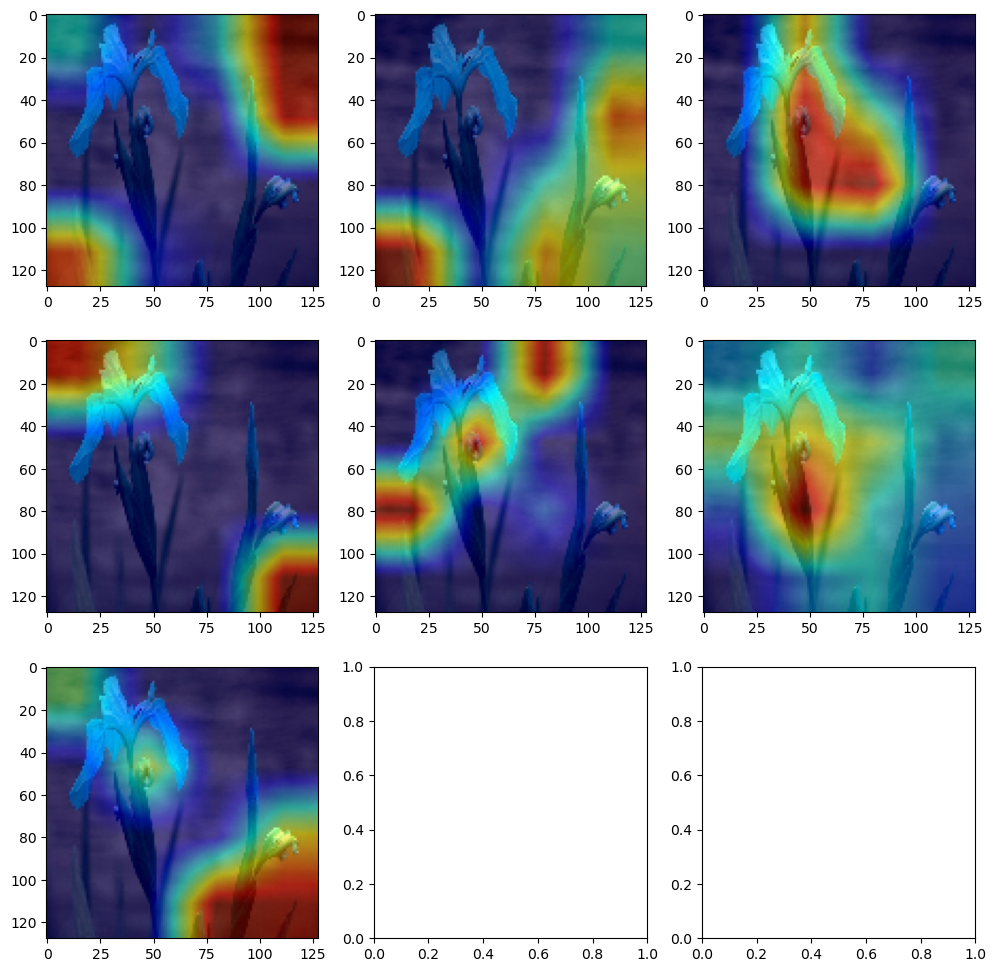

In [21]:
viz = openset_model.visualize_cams([img_open for i in range(openset_model.n_classes)], cams, max_width=3, output_path='fig2.png')

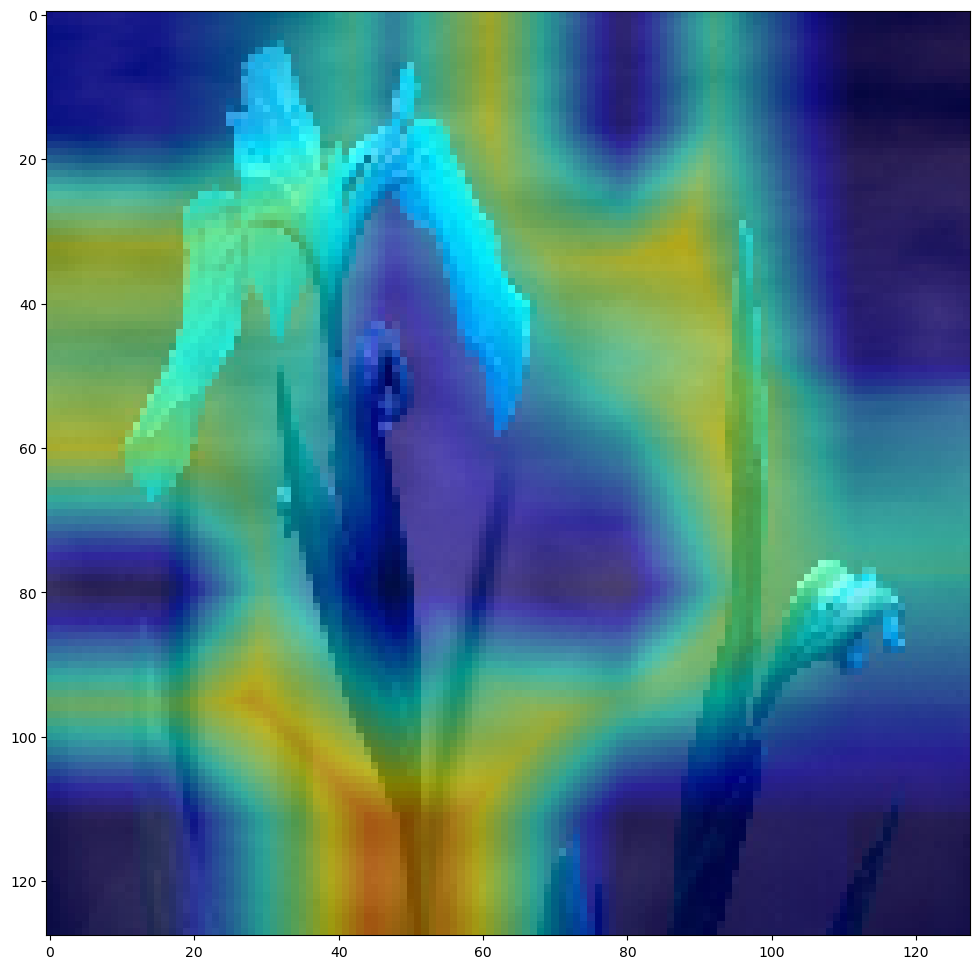

In [22]:
viz = openset_model.visualize_cams([img_open], [open_cam], max_width=1, output_path='fig2.png')

# Everything together
#### If the sample is in openset, the map shows everything that is irrelevant to all closed set classes,
#### If the sample is in closed set, the map shows everything that is related to the predicted class.

tensor([0.2595], device='cuda:0')
False
--> Sample is NOT in openset.


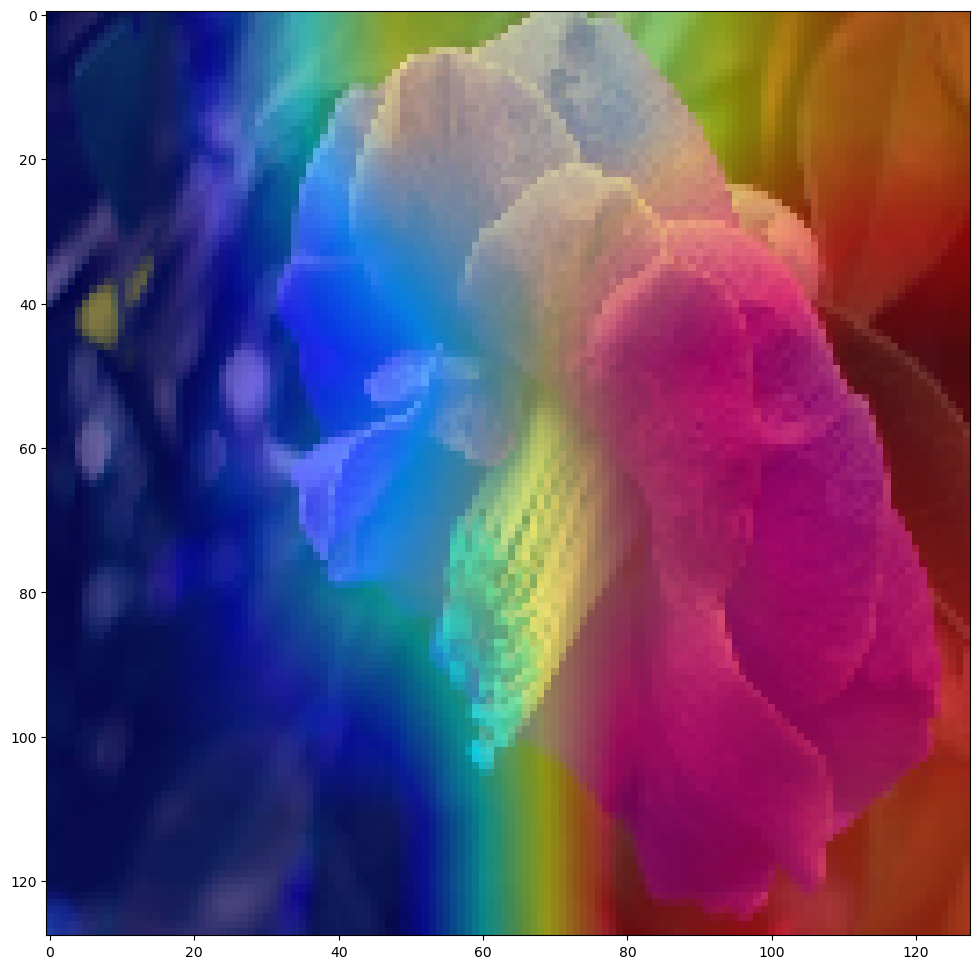

In [10]:
_ = openset_model.interpret(img_test, tensor_test, 'fig_test.png', 'GradCAM')

tensor([-2.0833], device='cuda:0')
True
--> Sample is  in openset.


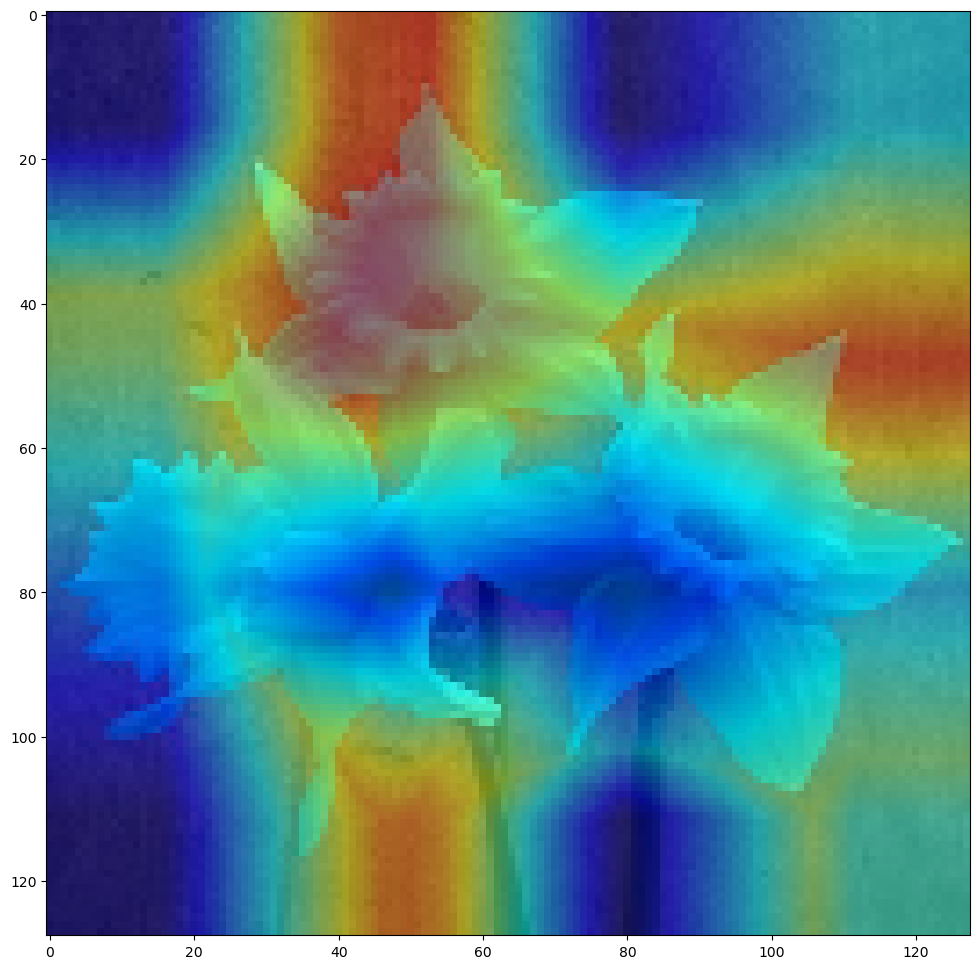

In [11]:
_ = openset_model.interpret(img_open, tensor_open, 'fig_open.png', 'GradCAM')